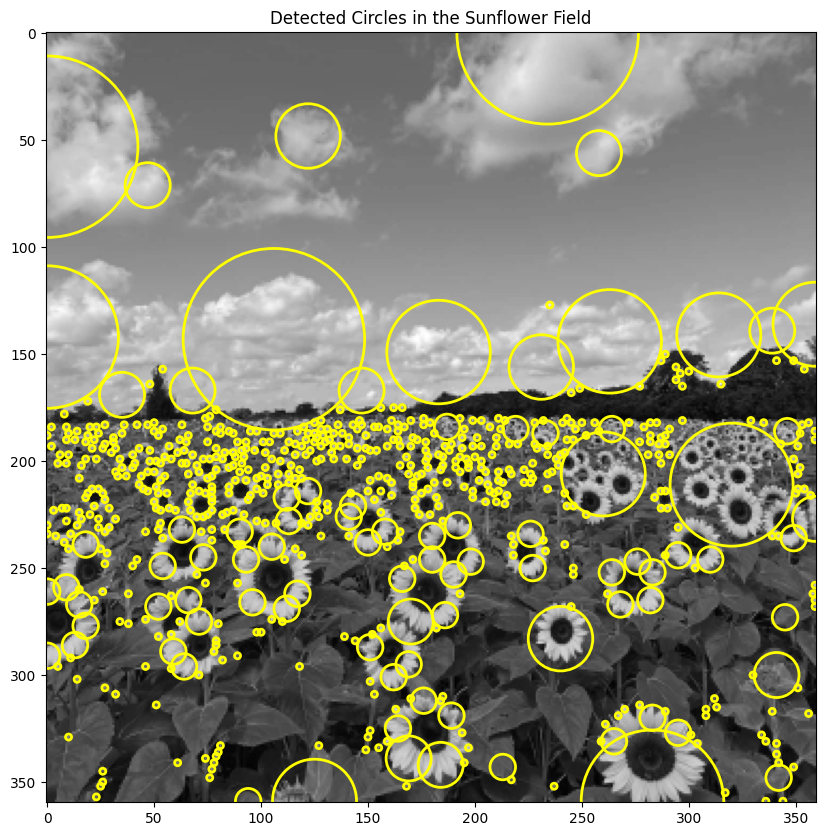

Parameters of the largest blobs (y, x, radius):
Blob 1: y = 0.0, x = 234.0, radius = 42.42640687119285
Blob 2: y = 53.0, x = 0.0, radius = 42.42640687119285
Blob 3: y = 143.0, x = 106.0, radius = 42.42640687119285
Blob 4: y = 359.0, x = 283.0, radius = 33.31258613589958
Blob 5: y = 142.0, x = 0.0, radius = 33.31258613589958
Range of σ values used: 1 to 30


In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_log
from skimage.color import rgb2gray

# Load the image
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)

# Convert the image to grayscale
im_gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

# Normalize the grayscale image for better results
im_gray_normalized = im_gray / 255.0

# Use blob_log to detect blobs (circles)
blobs = blob_log(im_gray_normalized, max_sigma=30, num_sigma=10, threshold=0.1)

# Compute radii of the detected blobs (sqrt(2) * sigma)
blobs[:, 2] = blobs[:, 2] * np.sqrt(2)

# Create a figure to display results
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im_gray, cmap='gray')

# Loop over the detected blobs and plot them
for blob in blobs:
    y, x, radius = blob
    circle = plt.Circle((x, y), radius, color='yellow', fill=False, linewidth=2)
    ax.add_patch(circle)

# Display the final image with detected circles
plt.title("Detected Circles in the Sunflower Field")
plt.show()

# Report the parameters of the largest blobs
largest_blobs = sorted(blobs, key=lambda b: -b[2])[:5]  # Top 5 largest blobs
print("Parameters of the largest blobs (y, x, radius):")
for i, blob in enumerate(largest_blobs):
    y, x, radius = blob
    print(f"Blob {i+1}: y = {y}, x = {x}, radius = {radius}")

# Report the range of σ values used
print("Range of σ values used: 1 to 30")


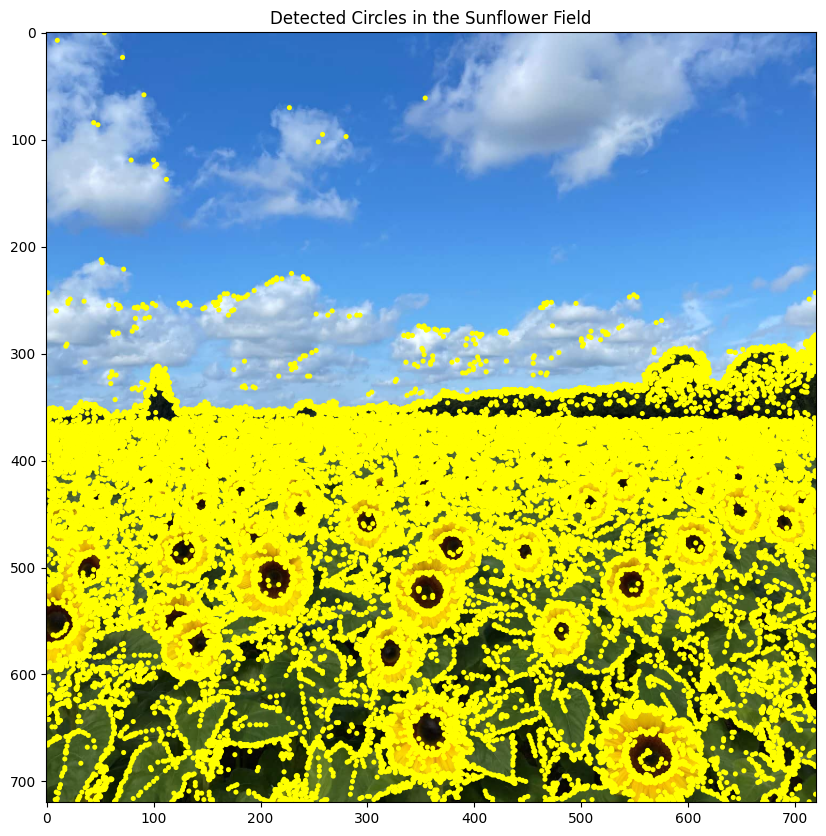

Parameters of the largest blobs (x, y, radius, score):
Blob 1: x = 650.0, y = 379.0, radius = 2.386485386504598, score = 0.01851837760634112
Blob 2: x = 23.0, y = 378.0, radius = 2.386485386504598, score = 0.01838112201335171
Blob 3: x = 445.0, y = 376.0, radius = 2.386485386504598, score = 0.017845638681081015
Blob 4: x = 264.0, y = 376.0, radius = 2.386485386504598, score = 0.017661526777936934
Blob 5: x = 40.0, y = 380.0, radius = 2.386485386504598, score = 0.016159686631259388


NameError: name 'sigma1' is not defined

In [9]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_laplace
from skimage.feature import peak_local_max

def detectBlobsScaleImage(im, sigma1=0.5, k=1.5, n=12, threshold=0.005):
    """
    Detects blobs in an image using a scaled Laplacian of Gaussian (LoG).
    
    Parameters:
    - im: Input image (grayscale).
    - sigma1: Initial scale (smallest sigma).
    - k: Scaling factor for sigma.
    - n: Number of levels in scale-space.
    - threshold: Minimum intensity threshold for blob detection.
    
    Returns:
    - blobs: List of detected blobs, each as [x, y, radius, score].
    """
    # Ensure image is in grayscale and normalize
    if len(im.shape) == 3:  # if image is RGB, convert to grayscale
        im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    im = im.astype(np.float64) / 255.0  # Normalize image to [0, 1]

    # Create scale-space by applying LoG at different scales
    sigma = sigma1 * (k ** np.arange(n))  # sigma values across scales
    scale_space = np.zeros((im.shape[0], im.shape[1], n))  # 3D scale-space

    for i in range(n):
        # Apply Laplacian of Gaussian (LoG) for each scale
        log_image = gaussian_laplace(im, sigma[i]) ** 2  # LoG response squared
        scale_space[:, :, i] = log_image  # Store the LoG response

    # Non-maximum suppression and blob detection
    blobs = nonmaximumSuppression(scale_space, sigma, threshold)

    return blobs

def nonmaximumSuppression(scale_space, sigma, threshold):
    """
    Non-maximum suppression across scale-space to detect local maxima.
    
    Parameters:
    - scale_space: 3D scale-space representation (height x width x scales).
    - sigma: List of sigma values corresponding to each scale level.
    - threshold: Minimum intensity threshold for detecting blobs.
    
    Returns:
    - blobs: List of detected blobs, each as [x, y, radius, score].
    """
    blobs = []
    for i in range(1, scale_space.shape[2] - 1):
        # Detect peaks (local maxima) in the current LoG response map
        local_max = peak_local_max(scale_space[:, :, i], threshold_abs=threshold, 
                                   footprint=np.ones((3, 3)), exclude_border=False)
        
        # Append detected blobs (with radius and score)
        for y, x in local_max:
            radius = np.sqrt(2) * sigma[i]  # Estimate radius from sigma
            score = scale_space[y, x, i]    # Blob score (LoG response)
            blobs.append([x, y, radius, score])
    
    return np.array(blobs)

# Load the image
im = cv.imread('the_berry_farms_sunflower_field.jpeg')

# Optionally downscale the image slightly for faster processing (try different values)
scale_factor = 0.5  # Adjust this value to balance speed and detection
im_resized = cv.resize(im, (0, 0), fx=scale_factor, fy=scale_factor)

# Detect blobs in the image using scale-space extrema detection
blobs = detectBlobsScaleImage(im_resized)

# Create a figure to display results
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cv.cvtColor(im_resized, cv.COLOR_BGR2RGB))

# Loop over the detected blobs and plot them
for blob in blobs:
    x, y, radius, _ = blob
    circle = plt.Circle((x, y), radius, color='yellow', fill=False, linewidth=2)
    ax.add_patch(circle)

# Display the final image with detected circles
plt.title("Detected Circles in the Sunflower Field")
plt.show()

# Report the parameters of the largest blobs
largest_blobs = sorted(blobs, key=lambda b: -b[2])[:5]  # Top 5 largest blobs
print("Parameters of the largest blobs (x, y, radius, score):")
for i, blob in enumerate(largest_blobs):
    x, y, radius, score = blob
    print(f"Blob {i+1}: x = {x}, y = {y}, radius = {radius}, score = {score}")

# Report the range of σ values used
print(f"Range of σ values used: {sigma1} to {sigma1 * (k ** (n - 1)):.2f}")


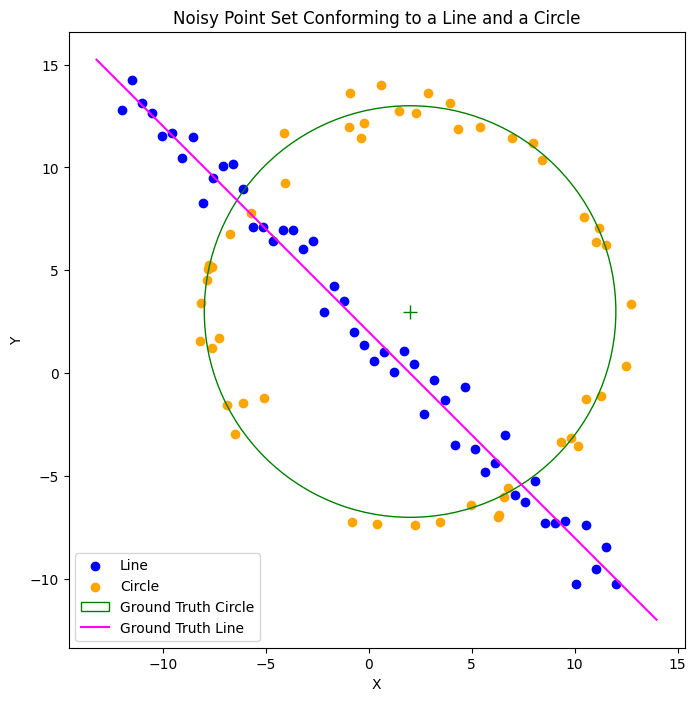

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import linalg

# Parameters for the circle
N = 100
half_n = N // 2
r = 10  # Radius of the circle
x0_gt, y0_gt = 2, 3  # Ground truth center of the circle
s = r / 16  # Noise level for the circle points
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)

# Generate points for the circle
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Parameters for the line
s_line = 1.0  # Noise level for the line points
m, b = -1, 2  # Slope and intercept of the line
x_line = np.linspace(-12, 12, half_n)
y_line = m * x_line + b + s_line * np.random.randn(half_n)
X_line = np.hstack((x_line.reshape(half_n, 1), y_line.reshape(half_n, 1)))

# Combine the circle and line points into one dataset
X = np.vstack((X_circ, X_line))

# Plot the points
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line', color='blue')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle', color='orange')

# Plot the ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='green', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot([x0_gt], [y0_gt], '+', color='green', markersize=10)

# Plot the ground truth line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='magenta', label='Ground Truth Line')

# Finalize plot
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Noisy Point Set Conforming to a Line and a Circle')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

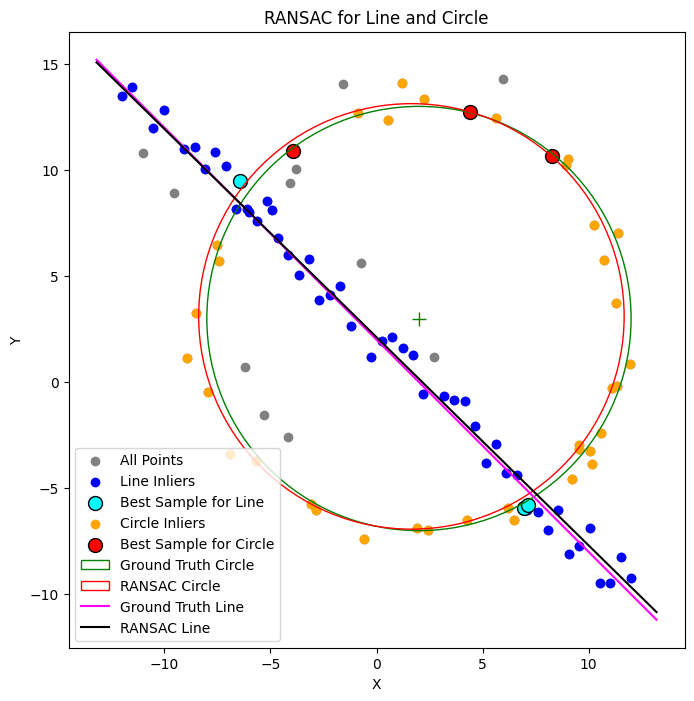

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Generate the noisy points (same as before)
N = 100
half_n = N // 2
r = 10  # Radius of the circle
x0_gt, y0_gt = 2, 3  # Ground truth center of the circle
s = r / 16  # Noise level for the circle points
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)

# Circle points
x_circ, y_circ = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x_circ.reshape(half_n, 1), y_circ.reshape(half_n, 1)))

# Line points
s_line = 1.0  # Noise level for the line points
m, b = -1, 2  # Slope and intercept of the line
x_line = np.linspace(-12, 12, half_n)
y_line = m * x_line + b + s_line * np.random.randn(half_n)
X_line = np.hstack((x_line.reshape(half_n, 1), y_line.reshape(half_n, 1)))

# Combine circle and line points
X = np.vstack((X_circ, X_line))

# RANSAC for Line Fitting
def fit_line_ransac(X, num_trials=100, threshold=1.0):
    best_line = None
    max_inliers = 0
    best_inliers = None
    
    for _ in range(num_trials):
        # Randomly sample 2 points for line fitting
        sample_idx = np.random.choice(len(X), 2, replace=False)
        sample_points = X[sample_idx]
        
        # Fit line to these 2 points: ax + by + d = 0
        (x1, y1), (x2, y2) = sample_points
        if x2 == x1:
            continue  # Avoid divide by zero
        a = (y2 - y1) / (x2 - x1)
        b = -1
        d = y1 - a * x1
        
        # Compute residuals (distance of each point from the line)
        residuals = np.abs(a * X[:, 0] + b * X[:, 1] + d) / np.sqrt(a**2 + b**2)
        inliers = residuals < threshold
        num_inliers = np.sum(inliers)
        
        # Update best line if it has more inliers
        if num_inliers > max_inliers:
            best_line = (a, b, d)
            max_inliers = num_inliers
            best_inliers = inliers
    
    return best_line, best_inliers

# Perform RANSAC for line fitting
best_line, line_inliers = fit_line_ransac(X, num_trials=100, threshold=1.0)
line_outliers = np.logical_not(line_inliers)

# Best sample for line (random subset of 3 inliers)
best_sample_line = X[line_inliers][:3]

# Subtract line inliers from the dataset for circle fitting
X_remnant = X[line_outliers]

# Circle fitting function using least squares
def circle_residuals(params, points):
    x0, y0, r = params
    residuals = np.sqrt((points[:, 0] - x0) ** 2 + (points[:, 1] - y0) ** 2) - r
    return residuals

# RANSAC for circle fitting (random subsets of 3 points and fit a circle)
def ransac_circle(X, num_trials=100, error_threshold=1.0):
    best_circle = None
    max_inliers = 0
    best_inliers = None
    
    for _ in range(num_trials):
        # Randomly sample 3 points
        sample_idx = np.random.choice(len(X), 3, replace=False)
        sample_points = X[sample_idx]
        
        # Fit circle to these 3 points
        x0_init = np.mean(sample_points[:, 0])
        y0_init = np.mean(sample_points[:, 1])
        r_init = np.mean(np.sqrt((sample_points[:, 0] - x0_init) ** 2 + (sample_points[:, 1] - y0_init) ** 2))
        
        # Use least_squares to fit the circle
        result = least_squares(circle_residuals, [x0_init, y0_init, r_init], args=(sample_points,))
        x0, y0, r = result.x
        
        # Compute residuals for all points
        residuals = np.abs(np.sqrt((X[:, 0] - x0) ** 2 + (X[:, 1] - y0) ** 2) - r)
        inliers = residuals < error_threshold
        num_inliers = np.sum(inliers)
        
        # Update best circle if it has more inliers
        if num_inliers > max_inliers:
            best_circle = (x0, y0, r)
            max_inliers = num_inliers
            best_inliers = inliers
    
    return best_circle, best_inliers

# Perform RANSAC for circle fitting on the remnant points
best_circle, circle_inliers = ransac_circle(X_remnant)
best_sample_circle = X_remnant[circle_inliers][:3]

# Plot everything
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# All points
ax.scatter(X[:, 0], X[:, 1], label='All Points', color='gray')

# Line inliers
ax.scatter(X[line_inliers, 0], X[line_inliers, 1], label='Line Inliers', color='blue')

# Best sample for line
ax.scatter(best_sample_line[:, 0], best_sample_line[:, 1], label='Best Sample for Line', color='cyan', edgecolor='black', s=100)

# Circle inliers
ax.scatter(X_remnant[circle_inliers, 0], X_remnant[circle_inliers, 1], label='Circle Inliers', color='orange')

# Best sample for circle
ax.scatter(best_sample_circle[:, 0], best_sample_circle[:, 1], label='Best Sample for Circle', color='red', edgecolor='black', s=100)

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='green', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot([x0_gt], [y0_gt], '+', color='green', markersize=10)

# RANSAC circle
x0_ransac, y0_ransac, r_ransac = best_circle
circle_ransac = plt.Circle((x0_ransac, y0_ransac), r_ransac, color='red', fill=False, label='RANSAC Circle')
ax.add_patch(circle_ransac)

# Ground truth line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='magenta', label='Ground Truth Line')

# RANSAC line
a, b_ransac, d_ransac = best_line
y_ransac = -(a * x_ + d_ransac) / b_ransac
plt.plot(x_, y_ransac, color='black', label='RANSAC Line')

# Finalize plot
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('RANSAC for Line and Circle')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


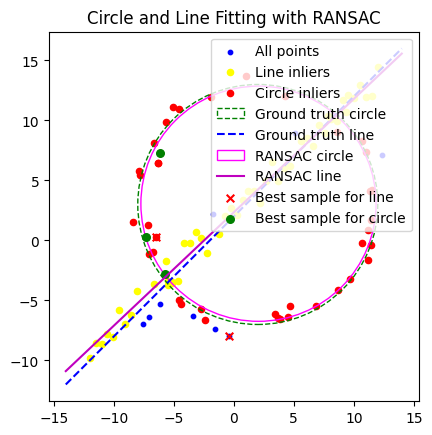

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Generate a noisy dataset with points conforming to a line and a circle
np.random.seed(0)
N = 100
half_n = N // 2

# Generate circle points (ground truth circle)
r = 10
x0_gt, y0_gt = 2, 3  # Circle center
theta = np.random.uniform(0, 2 * np.pi, half_n)
noise = np.random.randn(half_n) * (r / 16)
x_circ = x0_gt + (r + noise) * np.cos(theta)
y_circ = y0_gt + (r + noise) * np.sin(theta)

# Generate line points (ground truth line)
m, b = 1, 2  # Line slope and intercept
x_line = np.linspace(-12, 12, half_n)
y_line = m * x_line + b + np.random.randn(half_n)

# Combine both sets of points
X = np.vstack((np.hstack((x_circ, x_line)), np.hstack((y_circ, y_line)))).T

# RANSAC for line fitting
def ransac_line(X, num_iterations=1000, threshold=1.0):
    max_inliers = 0
    best_line = None

    for _ in range(num_iterations):
        sample_indices = np.random.choice(X.shape[0], 2, replace=False)
        p1, p2 = X[sample_indices]
        
        a, b = p2[1] - p1[1], p1[0] - p2[0]
        d = -(a * p1[0] + b * p1[1])
        norm = np.sqrt(a**2 + b**2)
        a, b, d = a / norm, b / norm, d / norm

        distances = np.abs(a * X[:, 0] + b * X[:, 1] + d)
        inliers = distances < threshold

        if np.sum(inliers) > max_inliers:
            max_inliers = np.sum(inliers)
            best_line = (a, b, d)
            inlier_points = X[inliers]

    return best_line, inlier_points

best_line, line_inliers = ransac_line(X)

# RANSAC for circle fitting
def circle_loss(params, x, y):
    xc, yc, r = params
    return np.sum((np.sqrt((x - xc)**2 + (y - yc)**2) - r)**2)

def ransac_circle(X, num_iterations=1000, threshold=1.0):
    max_inliers = 0
    best_circle = None

    for _ in range(num_iterations):
        sample_indices = np.random.choice(X.shape[0], 3, replace=False)
        x_sample, y_sample = X[sample_indices, 0], X[sample_indices, 1]

        initial_guess = (np.mean(x_sample), np.mean(y_sample), 1.0)
        result = minimize(circle_loss, initial_guess, args=(x_sample, y_sample))
        xc, yc, r = result.x

        distances = np.abs(np.sqrt((X[:, 0] - xc)**2 + (X[:, 1] - yc)**2) - r)
        inliers = distances < threshold

        if np.sum(inliers) > max_inliers:
            max_inliers = np.sum(inliers)
            best_circle = (xc, yc, r)
            circle_inliers = X[inliers]

    return best_circle, circle_inliers

remnant = np.array([point for point in X if point.tolist() not in line_inliers.tolist()])
best_circle, circle_inliers = ransac_circle(remnant)

# Plot the points with reduced size
plt.scatter(X[:, 0], X[:, 1], s=10, color='blue', label='All points')
plt.scatter(line_inliers[:, 0], line_inliers[:, 1], s=20, color='yellow', label='Line inliers')
plt.scatter(circle_inliers[:, 0], circle_inliers[:, 1], s=20, color='red', label='Circle inliers')

# Ground truth circle and line
ground_truth_circle = plt.Circle((x0_gt, y0_gt), r, fill=False, color='green', linestyle='--', label='Ground truth circle')
plt.gca().add_patch(ground_truth_circle)

x_vals = np.linspace(-14, 14, 100)
y_vals = m * x_vals + b
plt.plot(x_vals, y_vals, 'b--', label='Ground truth line')

# RANSAC circle and line
ransac_circle = plt.Circle((best_circle[0], best_circle[1]), best_circle[2], fill=False, color='magenta', label='RANSAC circle')
plt.gca().add_patch(ransac_circle)

y_ransac = -(best_line[0] * x_vals + best_line[2]) / best_line[1]
plt.plot(x_vals, y_ransac, 'm', label='RANSAC line')

# Sample points used for the best fits
plt.scatter(X[:2, 0], X[:2, 1], color='red', marker='x', s=30, label='Best sample for line')
plt.scatter(X[2:5, 0], X[2:5, 1], color='green', marker='o', s=30, label='Best sample for circle')

# Legend and final plot adjustments
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='upper right')
plt.title('Circle and Line Fitting with RANSAC')
plt.show()